In [1]:
!python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_sm
!pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.9/237.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.0/734.0 kB 56.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd

file_path = "scrapped_euractiv.csv"
df = pd.read_csv(file_path)
df.head()

,url,title,text
0,https://www.euractiv.com/section/tech/news/com...,Commission let tech firms water down key AI Ac...,Major tech companies have secured privileged a...
1,https://www.euractiv.com/section/tech/news/mep...,MEPs demand strict AI Act open source definiti...,Donec et orci aliquet nisl suscipit molestie s...
2,https://www.euractiv.com/section/tech/news/clu...,Club of MEPs demand strict AI Act open source ...,A total of 30 progressive MEPs warn the Commis...
3,https://www.euractiv.com/section/tech/news/ep-...,"EP vs. cheap Chinese goods, AI Continent launc...",Donec et orci aliquet nisl suscipit molestie s...
4,https://www.euractiv.com/section/tech/news/vir...,Virkkunen takes aim at AI Act reporting obliga...,Tech Commissioner Virkkunen is eyeing a revisi...


In [3]:
# Unwanted exact text block
unwanted_text = """Donec et orci aliquet nisl suscipit molestie sed sit amet tortor. Duis vel urna ac mi sollicitudin lacinia mollis sit amet lorem. Sed finibus erat nec libero scelerisque fringilla. Morbi at orci sed urna vulputate vulputate. Nulla facilisi. Donec et orci aliquet nisl suscipit molestie sed sit amet tortor.

Want to keep reading?

Get a subscription onEuractiv Proand elevate your political insight!"""

df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != '']
df = df[df['text'] != unwanted_text]

df = df
df

,url,title,text
0,https://www.euractiv.com/section/tech/news/com...,Commission let tech firms water down key AI Ac...,Major tech companies have secured privileged a...
2,https://www.euractiv.com/section/tech/news/clu...,Club of MEPs demand strict AI Act open source ...,A total of 30 progressive MEPs warn the Commis...
4,https://www.euractiv.com/section/tech/news/vir...,Virkkunen takes aim at AI Act reporting obliga...,Tech Commissioner Virkkunen is eyeing a revisi...
5,https://www.euractiv.com/section/tech/news/vir...,Virkkunen confirms a Chips Act 2.0 and outline...,\n\n\n\nExecutive Vice-President Henna Virkkun...
8,https://www.euractiv.com/section/tech/news/hun...,Hungary’s use of facial recognition likely vio...,In its latest amendment to the Hungarian Child...
...,...,...,...
2165,https://www.euractiv.com/section/global-europe...,Lula rallies G20 nations against world hunger ...,Brazil's President Luiz Inácio Lula da Silva o...
2166,https://www.euractiv.com/section/economy-jobs/...,"Meta releases most powerful open AI model yet,...",Metareleasedtheir flagship text-only model Lla...
2167,https://www.euractiv.com/section/tech/news/med...,"Media literacy, fact-checking investment neede...",This article is part of our special reportAI4T...
2168,https://www.euractiv.com/section/global-europe...,Azerbaijan intensifies anti-colonial rhetoric ...,This article is part of our special reportThe ...


In [4]:
keywords = [
    "AI Act",
    "Artificial Intelligence Act",
    "EU AI regulation",
    "European AI Act"
]

df = df[
    df['title'].str.contains('|'.join(keywords), case=False, na=False) |
    df['text'].str.contains('|'.join(keywords), case=False, na=False)
]

In [5]:
import spacy
import string

nlp = spacy.load("en_core_web_trf")
texts = df['text'].tolist()

#NER for PERSON, ORG, GPE
actor_lists = []

for doc in nlp.pipe(texts, batch_size=16):
    actors = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG", "GPE"]:
            actors.append(ent.text)
    actor_lists.append(actors)

df['raw_actors'] = actor_lists


#normalisation
def normalize_actor_list(actor_list):
    cleaned = []
    for actor in actor_list:
        actor = actor.strip()
        actor = actor.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
        actor = actor.title()  # title case
        if len(actor.split()) > 1 or len(actor) > 3:  # remove very short/single-word names
            cleaned.append(actor)
    return list(set(cleaned))  # remove duplicates

df['cleaned_actors'] = df['raw_actors'].apply(normalize_actor_list)
df['cleaned_actors']

/tmp/ipython-input-2081699222.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['raw_actors'] = actor_lists
/tmp/ipython-input-2081699222.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_actors'] = df['raw_actors'].apply(normalize_actor_list)


,cleaned_actors
0,"[Lobby Control, Euractiv, Tocommissionwebsites..."
2,"[Markéta Gregorová, The Open Source Initiative..."
4,"[Frederico Oliveira Da Silva, Commission, Juri..."
5,"[Henna Virkkunen, Euractiv, Commission, Virkku..."
8,"[China, The European Parliament, Daniel Freund..."
...,...
1850,"[Eliza Gkritsi, Euractiv, Ai Office, Commission]"
1862,"[Chatgpt, Renew, Clara Chappaz, Kim Van Sparre..."
1875,"[Scott Morton, Taiwan, Union, Brussels, Farmer..."
1984,"[Algorithmwatch, Andorra, Iceland, Fanucci, Mo..."


In [6]:
list(df['cleaned_actors'])

[['Lobby Control',
  'Euractiv',
  'Tocommissionwebsites',
  'Thomas Regnier',
  'Commission',
  'Wavestone',
  'Accenture',
  'Ceps',
  'Corporate Europe Observatory',
  'Intellera',
  'Google Cloud',
  'Laura Nicolas',
  'Big Tech'],
 ['Markéta Gregorová',
  'The Open Source Initiative',
  'Meta',
  'Commission',
  'Facebook',
  'Greens',
  'European Competitiveness',
  'Birgit Sippel',
  'Llama'],
 ['Frederico Oliveira Da Silva',
  'Commission',
  'Juri',
  'Virkkunen',
  'The European Consumer Organisation',
  'Beuc',
  'Committee On Legal Affairs'],
 ['Henna Virkkunen', 'Euractiv', 'Commission', 'Virkkunen', 'Paris', 'Google'],
 ['China',
  'The European Parliament',
  'Daniel Freund',
  'Caroli',
  'Laura Caroli',
  'Viktor Orbáns',
  'Hungary',
  'The Hungarian Parliament',
  'Budapest',
  'Freund',
  'Hungarian Helsinki Committeesaidthat',
  'Orbán',
  'Russia',
  'Viktor Orbán'],
 ['Sioli',
  'Euractiv',
  'Thomas Regnier',
  'Commission',
  'Lucilla Sioli',
  'Apanelon',
  'A

In [7]:
# Actor merging rules
merge_map = {
    # European Commission
    "Commission": "European Commission",
    "The Eu Commission": "European Commission",
    "The European Commission": "European Commission",
    "Newcommission": "European Commission",

    # Google
    "Google Cloud": "Google",
    "Gemini": "Google",
    "Google Deepmind": "Google",
    "Alphabet": "Google",
    "Google": "Google",

    # Facebook → META
    "Facebook": "META",
    "Facebook ve diğer ürünler": "META",
    "META": "META",


    # Parliament
    "Parliament": "European Parliament",
    "The European Parliament": "European Parliament",
    "The Eu Parliament": "European Parliament",
    "The European Parliaments": "European Parliament",
    "The European Parliament’S": "European Parliament",
    "The \xa0European Parliament’S": "European Parliament",
    "Theeuropean Parliamentand": "European Parliament",
    "European Parliament": "European Parliament",

    # Council
    "Council": "The Council of the European Union",
    'The council Of The Euin': "The Council of the European Union",
    'The Eu': "The Council of the European Union",
    "The Eu Council Of Ministers": "The Council of the European Union",
    "The Eu Councils Of Ministers": "The Council of the European Union",
    "The Eu Council": "The Council of the European Union",
    "The Council Of The Eu": "The Council of the European Union",
    "Eu Council": "The Council of the European Union",
    "Thecouncil Of The Euin": "The Council of the European Union",
    "The European Union": "The Council of the European Union",
    "The Council of the European Union": "The Council of the European Union",

    # AI Office
    "The Ai Office": "The EU AI Office",
    "The Ai Offices": "The EU AI Office",
    "The Ai Office’S": "The EU AI Office",
    "An Ai Office": "The EU AI Office",
    "Office": "The EU AI Office",
    "The EU AI Office": "The EU AI Office",

    # Country Normalization
    "America": "United States",
    "US": "United States",
    "united states": "United States",
    "The Us": "United States",
    "Us": "United States",
    "Washington": "United States",
    "United States": "United States",
    "United States Of America": "United States",

    # Merging Individuals
    "Orban": "Victor Orban",
    "Victor": "Victor Orban",
    "Viktor Orbáns": "Victor Orban",
    "Virkkunen": "Henna Virkkunen",
    "Henna Virkkunen": "Henna Virkkunen",
    "Caroli": "Laura Caroli",
    "Laura Caroli": "Laura Caroli",
    "Maydell": "Eva Maydell",
    "Eva Maydell": "Eva Maydell",
    "Barrot": "Jean Noel Barrot",
    'Jeannoël Barrot': "Jean Noel Barrot",
    "Jean Noel Barrot": "Jean Noel Barrot",
    "Cruz": "Ted Cruz",
    "Ted Cruz": "Ted Cruz",
    "Meloni": "Georgia Meloni",
    "Georgia Meloni": "Georgia Meloni",
    "Sioli": "Lucilla Sioli",
    "Lucilla Sioli": "Lucilla Sioli",
    "Šefčovič": "Maros Sefcovic",
    "Maros Sefcovic": "Maros Sefcovic",
    "Tiyavorabun": "Blue Tiyavorabun",
    "Blue Tiyavorabun": "Blue Tiyavorabun",
    "Reynders": "Didier Reynders",
    "Didier Reynders": "Didier Reynders",
    "Tudorache": "Dragoș Tudorache",
    "Dragoș Tudorache": "Dragoș Tudorache",
    "Benifei": "Brando Benifei",
    "Brando Benifei": "Brando Benifei",
    "Sippel": "Birget Sippel",
    "Birget Sippel": "Birget Sippel",
    "Von Der Leyen": "Ursula Von Der Leyen",
    "Ursula Von Der Leyen": "Ursula Von Der Leyen",
    "Macron": "Emanuel Macron",
    "Emanuel Macron": "Emanuel Macron",
    "Biden": "Joe Biden",
    "Joe Biden": "Joe Biden",
    "Tusk": "Donald Tusk",
    "Donald Tusk": "Donald Tusk",
    "Fico": "Robert Fico",
    "Robert Fico": "Robert Fico",
    "Musk": "Elon Musk",
    "Elon Musk": "Elon Musk",
    "Altman": "Sam Altman",
    "Sam Altman": "Sam Altman",
    "Trump": "Donald Trump",
    "donald": "Donald Trump",
    "DONALD": "Donald Trump",
    "DONALD TRUMP": "Donald Trump",
    "donald trump": "Donald Trump",
    "trump": "Donald Trump",
    "TRUMP": "Donald Trump",
    "Donald": "Donald Trump",
    "Donald Trump": "Donald Trump",

    # Organizations
    "Edri": "European Digital Rights",
    "European Digital Rights": "European Digital Rights",
    "Open Markets": "Open Markets Institute",
    "Open Markets Institute": "Open Markets Institute",
    "Openai": "OpenAI",
    "Chatgpt": "OpenAI",
    "ChatGPT": "OpenAI",
    "Open AI": "OpenAI",
    "OpenAI": "OpenAI",
    "Florence": "Microsoft",
    "Microsoft": "Microsoft",
    "Tokyo": "Japan",
    "Japan": "Japan",
    "Mistral": "Mistral Ai",
    "Mistral AI": "Mistral Ai",
    "Mistral Ai": "Mistral Ai",
    "Stanford": "Stanford University",
    "Stanford University": "Stanford University",
    "Ai Act": "AI Act",
    "Commerce Department": "Commerce Department",

    # Centre for Democracy
    "The Equity And Data Programme": "Centre for Democracy and Technology",
    "Cdt Europe": "Centre for Democracy and Technology",
    "Laura Lazaro Cabrera": "Centre for Democracy and Technology",
    "Edps": "Centre for Democracy and Technology",
    "The Centre For Democracy  Technology": "Centre for Democracy and Technology",
    "Centre for Democracy and Technology": "Centre for Democracy and Technology",

    # Telecom Council
    "The Telecom Council": "The Telecom Council",
    "Telecom Council": "The Telecom Council",
    "The Telecom Working Party": "The Telecom Council",

    # Irish Council
    "The Irish Council For Civil Liberties": "The Irish Council For Civil Liberties",
    "Civil Liberties Committee": "The Irish Council For Civil Liberties"
}

# Actors to drop
drop_list = {
    "Senate", 'Euractiv', 'Big Tech', 'Lobby Control', 'Llama', 'European Competitiveness', 'Juri', 'Hungary', 'Budapest',
    'Alice Taylorbraçe', 'Theeuropean Union’S', 'Strasbourg', 'France', 'Spain', 'Italy',
    'Germany', 'Contexte', 'Brussels', 'Paris', 'The Netherlands', 'Ukandchinahave', 'California', 'Austria', 'Euractivthis',
    'Luxembourg', 'Luxembourg', 'Directorategeneral', 'Netherlands', 'The Eu Artificial Intelligence’S', 'Berlin',
    'Meps', 'Left', 'The Czech Republic', 'Oneuractiv Proand', 'Union', 'Rome', 'Budapest', 'Andrews', 'Blairmania',
    'Ireland', 'Europe', 'Baltics', 'The Great Man Of History', 'López', 'Iraq', 'Euractivs Advocacy Lab', 'Keynes',
    'Kenya', 'A Universal Basic Income', 'The New York Times', 'Modern','Poland', 'Groupnoname05716', 'Eu Ai Champions',
    'The Third Reich', 'Ai Factories', 'Portugal', 'Capitals', 'Madrid', 'Balkans', 'Eurozone', 'Bulgaria', 'Bratislava',
    'Romania', 'Palestine', 'Lisbon', 'Prague', 'The Capitals', 'South', 'Slovakia', 'Sweden', 'Diversity Equity And Inclusion',
    'Malta',  'Cnbc reported', 'The New York Times', 'Strasbourg', 'The Digital Fairness Check', 'The washington Post reportedon',
    'Thefinancial Timesreported',  'Reutersreported', 'Regulation And Compliance', 'Amsterdam', 'Denmark', 'Court', 'Copenhagen',
    'Ireland', 'Belgium', 'Reuters', 'Luxembourg', 'Reportedthefinancial Times',  'Bloomberg Opinion', 'Czechia', 'Estonia',
    'Farmer', 'Iceland', 'Vilnius', 'Andorra', 'Lithuania', 'San Marino', 'Norway', "AI Act"

}

def merge_and_clean(actors):
    merged = []
    for actor in actors:
        actor = actor.strip()
        if actor in drop_list:
            continue
        mapped = merge_map.get(actor, actor)
        merged.append(mapped)
    return sorted(list(set(merged)))  # remove duplicates

df['final_actors'] = df['cleaned_actors'].apply(merge_and_clean)
df[['title', 'final_actors']].head(10)

/tmp/ipython-input-1499652989.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_actors'] = df['cleaned_actors'].apply(merge_and_clean)


,title,final_actors
0,Commission let tech firms water down key AI Ac...,"[Accenture, Ceps, Corporate Europe Observatory..."
2,Club of MEPs demand strict AI Act open source ...,"[Birgit Sippel, European Commission, Greens, M..."
4,Virkkunen takes aim at AI Act reporting obliga...,"[Beuc, Committee On Legal Affairs, European Co..."
5,Virkkunen confirms a Chips Act 2.0 and outline...,"[European Commission, Google, Henna Virkkunen]"
8,Hungary’s use of facial recognition likely vio...,"[China, Daniel Freund, European Parliament, Fr..."
10,Commission line confused on potential AI act r...,"[Ai Office, Apanelon, European Commission, Luc..."
15,Civil society rallies for human rights as AI A...,"[Access Now, Amnesty International, Blue Tiyav..."
18,The AI Act compliance deadline: harnessing eva...,"[Ai Safety Institute, Apollo Research, Eu Ai O..."
23,EU’s much-heralded AI Act agreed by EU Parliam...,"[Centre for Democracy and Technology, European..."
25,"The AI Act vs. deepfakes: A step forward, but ...","[Cristina Vanberghen, European Commission, The..."


In [8]:
list(df['final_actors'])

[['Accenture',
  'Ceps',
  'Corporate Europe Observatory',
  'European Commission',
  'Google',
  'Intellera',
  'Laura Nicolas',
  'Thomas Regnier',
  'Tocommissionwebsites',
  'Wavestone'],
 ['Birgit Sippel',
  'European Commission',
  'Greens',
  'META',
  'Markéta Gregorová',
  'Meta',
  'The Open Source Initiative'],
 ['Beuc',
  'Committee On Legal Affairs',
  'European Commission',
  'Frederico Oliveira Da Silva',
  'Henna Virkkunen',
  'The European Consumer Organisation'],
 ['European Commission', 'Google', 'Henna Virkkunen'],
 ['China',
  'Daniel Freund',
  'European Parliament',
  'Freund',
  'Hungarian Helsinki Committeesaidthat',
  'Laura Caroli',
  'Orbán',
  'Russia',
  'The Hungarian Parliament',
  'Victor Orban',
  'Viktor Orbán'],
 ['Ai Office',
  'Apanelon',
  'European Commission',
  'Lucilla Sioli',
  'Maros Sefcovic',
  'Thomas Regnier'],
 ['Access Now',
  'Amnesty International',
  'Blue Tiyavorabun',
  'Commision',
  'European Commission',
  'European Digital Rig

In [9]:
# Q1: Identifying key actors (nodes) and clusters
# ============================================================================

from collections import Counter, defaultdict
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

all_actors = []
for actor_list in df['final_actors']:
    all_actors.extend(actor_list)

actor_counts = Counter(all_actors)
print("Top 20 most mentioned actors:")
for actor, count in actor_counts.most_common(20):
    print(f"{actor}: {count}")

Top 20 most mentioned actors:
European Commission: 60
European Parliament: 43
The Council of the European Union: 33
The EU AI Office: 20
Brando Benifei: 15
Nathalie Weatherald: 15
Google: 13
Dragoș Tudorache: 12
OpenAI: 11
Alice Taylor: 10
Meta: 8
China: 8
Microsoft: 8
Henna Virkkunen: 6
Oecd: 6
The Telecom Council: 6
Donald Trump: 6
Ursula Von Der Leyen: 6
Greens: 5
Mistral Ai: 5


Building actor network...


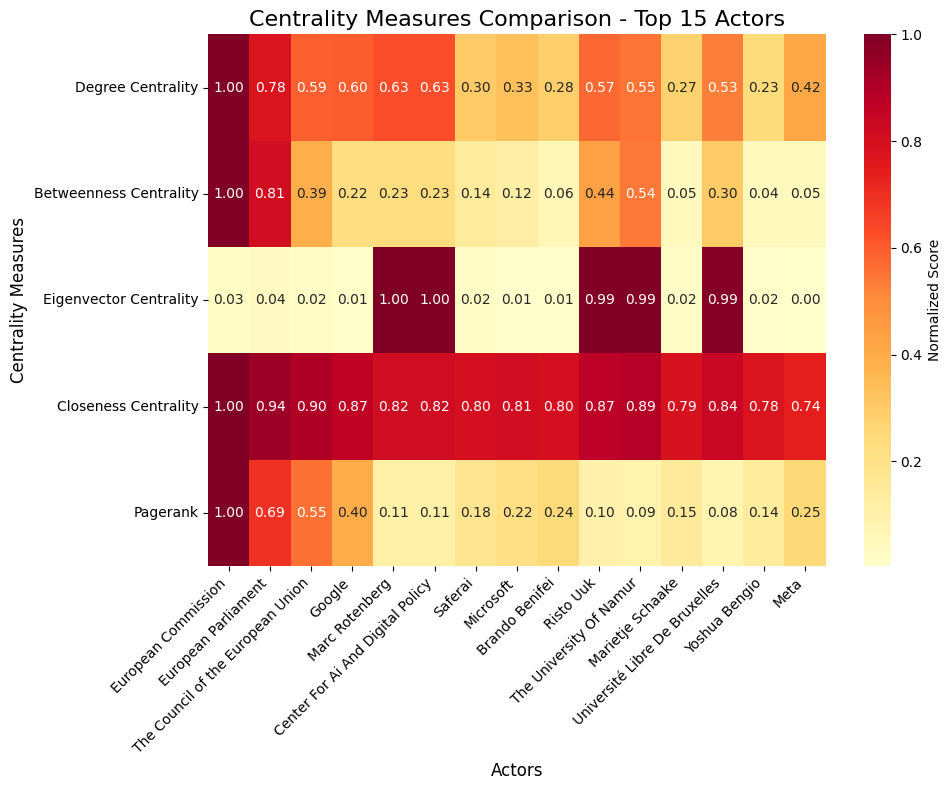

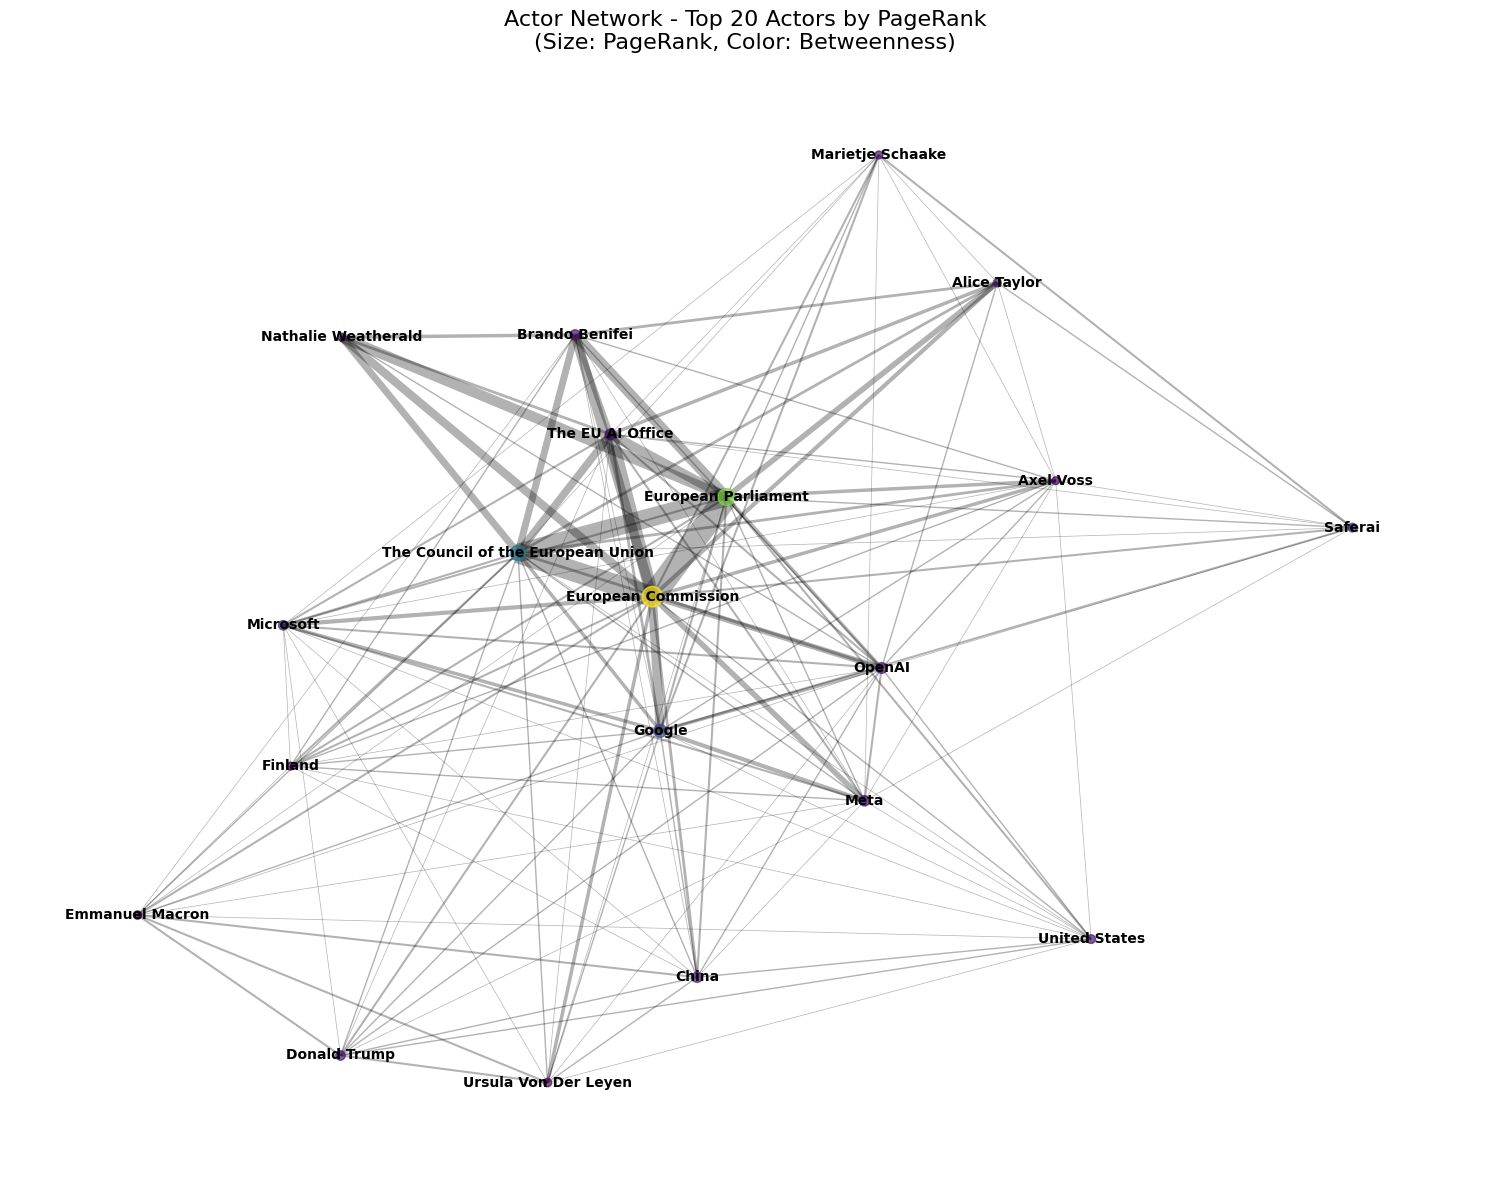

Network has 782 nodes and 31517 edges

Calculating centrality measures...

Creating centrality dataframe...

Analyzing actor influence patterns...

Top 20 Most Central Actors (by average rank):
                                 actor  frequency   avg_rank  \
3                  European Commission         60   2.000000   
23                 European Parliament         43   2.666667   
57   The Council of the European Union         33   4.500000   
4                               Google         13   7.833333   
113                     Marc Rotenberg          2  11.333333   
95    Center For Ai And Digital Policy          2  11.333333   
125                            Saferai          5  11.500000   
53                           Microsoft          8  12.166667   
84                      Brando Benifei         15  12.666667   
266                          Risto Uuk          2  13.000000   
485            The University Of Namur          2  13.833333   
114                   Marietje Schaake

In [10]:
# Centrality Analysis
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

def build_actor_network(df):
    """Build a co-occurrence network from actors appearing in the same articles"""
    G = nx.Graph()

    #
    all_actors = []
    for actors in df['final_actors']:
        all_actors.extend(actors)

    actor_counts = Counter(all_actors)


    for actor, count in actor_counts.items():
        G.add_node(actor, frequency=count)


    for idx, actors in enumerate(df['final_actors']):
        for i in range(len(actors)):
            for j in range(i+1, len(actors)):
                actor1, actor2 = actors[i], actors[j]
                if G.has_edge(actor1, actor2):
                    G[actor1][actor2]['weight'] += 1
                else:
                    G.add_edge(actor1, actor2, weight=1)

    return G, actor_counts

def calculate_centrality_measures(G):
    """Calculate various centrality measures for the network"""
    centrality_measures = {}

    # Degree Centrality - how connected is each node
    centrality_measures['degree'] = nx.degree_centrality(G)

    # Betweenness Centrality - which nodes are bridges between others
    centrality_measures['betweenness'] = nx.betweenness_centrality(G, weight='weight')

    # Eigenvector Centrality - connection to well-connected nodes
    try:
        centrality_measures['eigenvector'] = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    except:
        centrality_measures['eigenvector'] = {node: 0 for node in G.nodes()}

    # Closeness Centrality - how close to all other nodes
    centrality_measures['closeness'] = nx.closeness_centrality(G, distance='weight')

    # PageRank - importance based on connections
    centrality_measures['pagerank'] = nx.pagerank(G, weight='weight')

    return centrality_measures

def create_centrality_dataframe(G, centrality_measures, actor_counts):
    """Create a comprehensive dataframe with all centrality measures"""
    centrality_df = pd.DataFrame({
        'actor': list(G.nodes()),
        'frequency': [actor_counts.get(actor, 0) for actor in G.nodes()],
        'degree_centrality': [centrality_measures['degree'].get(actor, 0) for actor in G.nodes()],
        'betweenness_centrality': [centrality_measures['betweenness'].get(actor, 0) for actor in G.nodes()],
        'eigenvector_centrality': [centrality_measures['eigenvector'].get(actor, 0) for actor in G.nodes()],
        'closeness_centrality': [centrality_measures['closeness'].get(actor, 0) for actor in G.nodes()],
        'pagerank': [centrality_measures['pagerank'].get(actor, 0) for actor in G.nodes()]
    })

    for col in ['frequency', 'degree_centrality', 'betweenness_centrality',
                'eigenvector_centrality', 'closeness_centrality', 'pagerank']:
        centrality_df[f'{col}_rank'] = centrality_df[col].rank(ascending=False, method='dense')
    rank_cols = [col for col in centrality_df.columns if col.endswith('_rank')]
    centrality_df['avg_rank'] = centrality_df[rank_cols].mean(axis=1)
    centrality_df = centrality_df.sort_values('avg_rank')
    return centrality_df

def visualize_network(G, centrality_measures, top_n=20):
    """Visualize the network with node sizes based on centrality"""
    plt.figure(figsize=(15, 12))


    top_nodes = sorted(centrality_measures['pagerank'].items(),
                      key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = [node[0] for node in top_nodes]


    subgraph = G.subgraph(top_node_names)


    pos = nx.spring_layout(subgraph, k=2, iterations=50)


    node_sizes = [centrality_measures['pagerank'][node] * 10000
                  for node in subgraph.nodes()]


    node_colors = [centrality_measures['betweenness'][node]
                   for node in subgraph.nodes()]


    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,
                          node_color=node_colors, cmap='viridis', alpha=0.7)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3,
                          width=[subgraph[u][v]['weight']*0.5 for u, v in subgraph.edges()])

    plt.title(f"Actor Network - Top {top_n} Actors by PageRank\n(Size: PageRank, Color: Betweenness)",
              fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_centrality_comparison(centrality_df, top_n=20):
    """Create a heatmap comparing different centrality measures"""

    top_actors = centrality_df.head(top_n)

    centrality_cols = ['degree_centrality', 'betweenness_centrality', 'eigenvector_centrality', 'closeness_centrality', 'pagerank']

    normalized_data = top_actors[centrality_cols].copy()
    for col in centrality_cols:
        max_val = normalized_data[col].max()
        if max_val > 0:
            normalized_data[col] = normalized_data[col] / max_val


    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_data.T,
                xticklabels=top_actors['actor'],
                yticklabels=[col.replace('_', ' ').title() for col in centrality_cols],
                cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Normalized Score'})
    plt.title(f'Centrality Measures Comparison - Top {top_n} Actors', fontsize=16)
    plt.xlabel('Actors', fontsize=12)
    plt.ylabel('Centrality Measures', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def analyze_actor_influence(centrality_df):
    """Analyze and categorize actors based on their influence patterns"""

    categories = []

    for _, row in centrality_df.iterrows():
        if row['betweenness_centrality_rank'] <= 5:
            categories.append('Bridge/Connector')
        elif row['eigenvector_centrality_rank'] <= 5:
            categories.append('Well-Connected')
        elif row['frequency_rank'] <= 5:
            categories.append('Highly Mentioned')
        elif row['pagerank_rank'] <= 10:
            categories.append('Influential')
        else:
            categories.append('Peripheral')

    centrality_df['influence_category'] = categories

    return centrality_df


def run_centrality_analysis(df):
    """Main function to run the complete centrality analysis"""
    print("Building actor network...")
    G, actor_counts = build_actor_network(df)
    centrality_measures = calculate_centrality_measures(G)
    centrality_df = create_centrality_dataframe(G, centrality_measures, actor_counts)
    centrality_df = analyze_actor_influence(centrality_df)
    plot_centrality_comparison(centrality_df, top_n=15)
    visualize_network(G, centrality_measures, top_n=20)


    print(f"Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print("\nCalculating centrality measures...")
    print("\nCreating centrality dataframe...")
    print("\nAnalyzing actor influence patterns...")
    print("\nTop 20 Most Central Actors (by average rank):")
    print(centrality_df[['actor', 'frequency', 'avg_rank', 'influence_category']].head(20))
    print("\nInfluence Category Distribution:")
    print(centrality_df['influence_category'].value_counts())
    print("\nGenerating network visualization...")
    print("\nGenerating centrality comparison heatmap...")
    print("\n=== KEY INSIGHTS ===")
    print("\nMost Central Actors (Top 5 by PageRank):")

    for idx, row in centrality_df.head(5).iterrows():
        print(f"- {row['actor']}: PageRank={row['pagerank']:.4f}, "
              f"Betweenness={row['betweenness_centrality']:.4f}, "
              f"Mentioned {row['frequency']} times")


    bridge_actors = centrality_df[centrality_df['influence_category'] == 'Bridge/Connector']
    if not bridge_actors.empty:
        print("\nKey Bridge/Connector Actors:")
        for _, row in bridge_actors.head(5).iterrows():
            print(f"- {row['actor']}: Connects different parts of the network")

    return G, centrality_df, centrality_measures


G, centrality_df, centrality_measures = run_centrality_analysis(df)


centrality_df.to_csv('actor_centrality_analysis.csv', index=False)
print("\nResults saved to 'actor_centrality_analysis.csv'")

Creating enhanced network visualization...


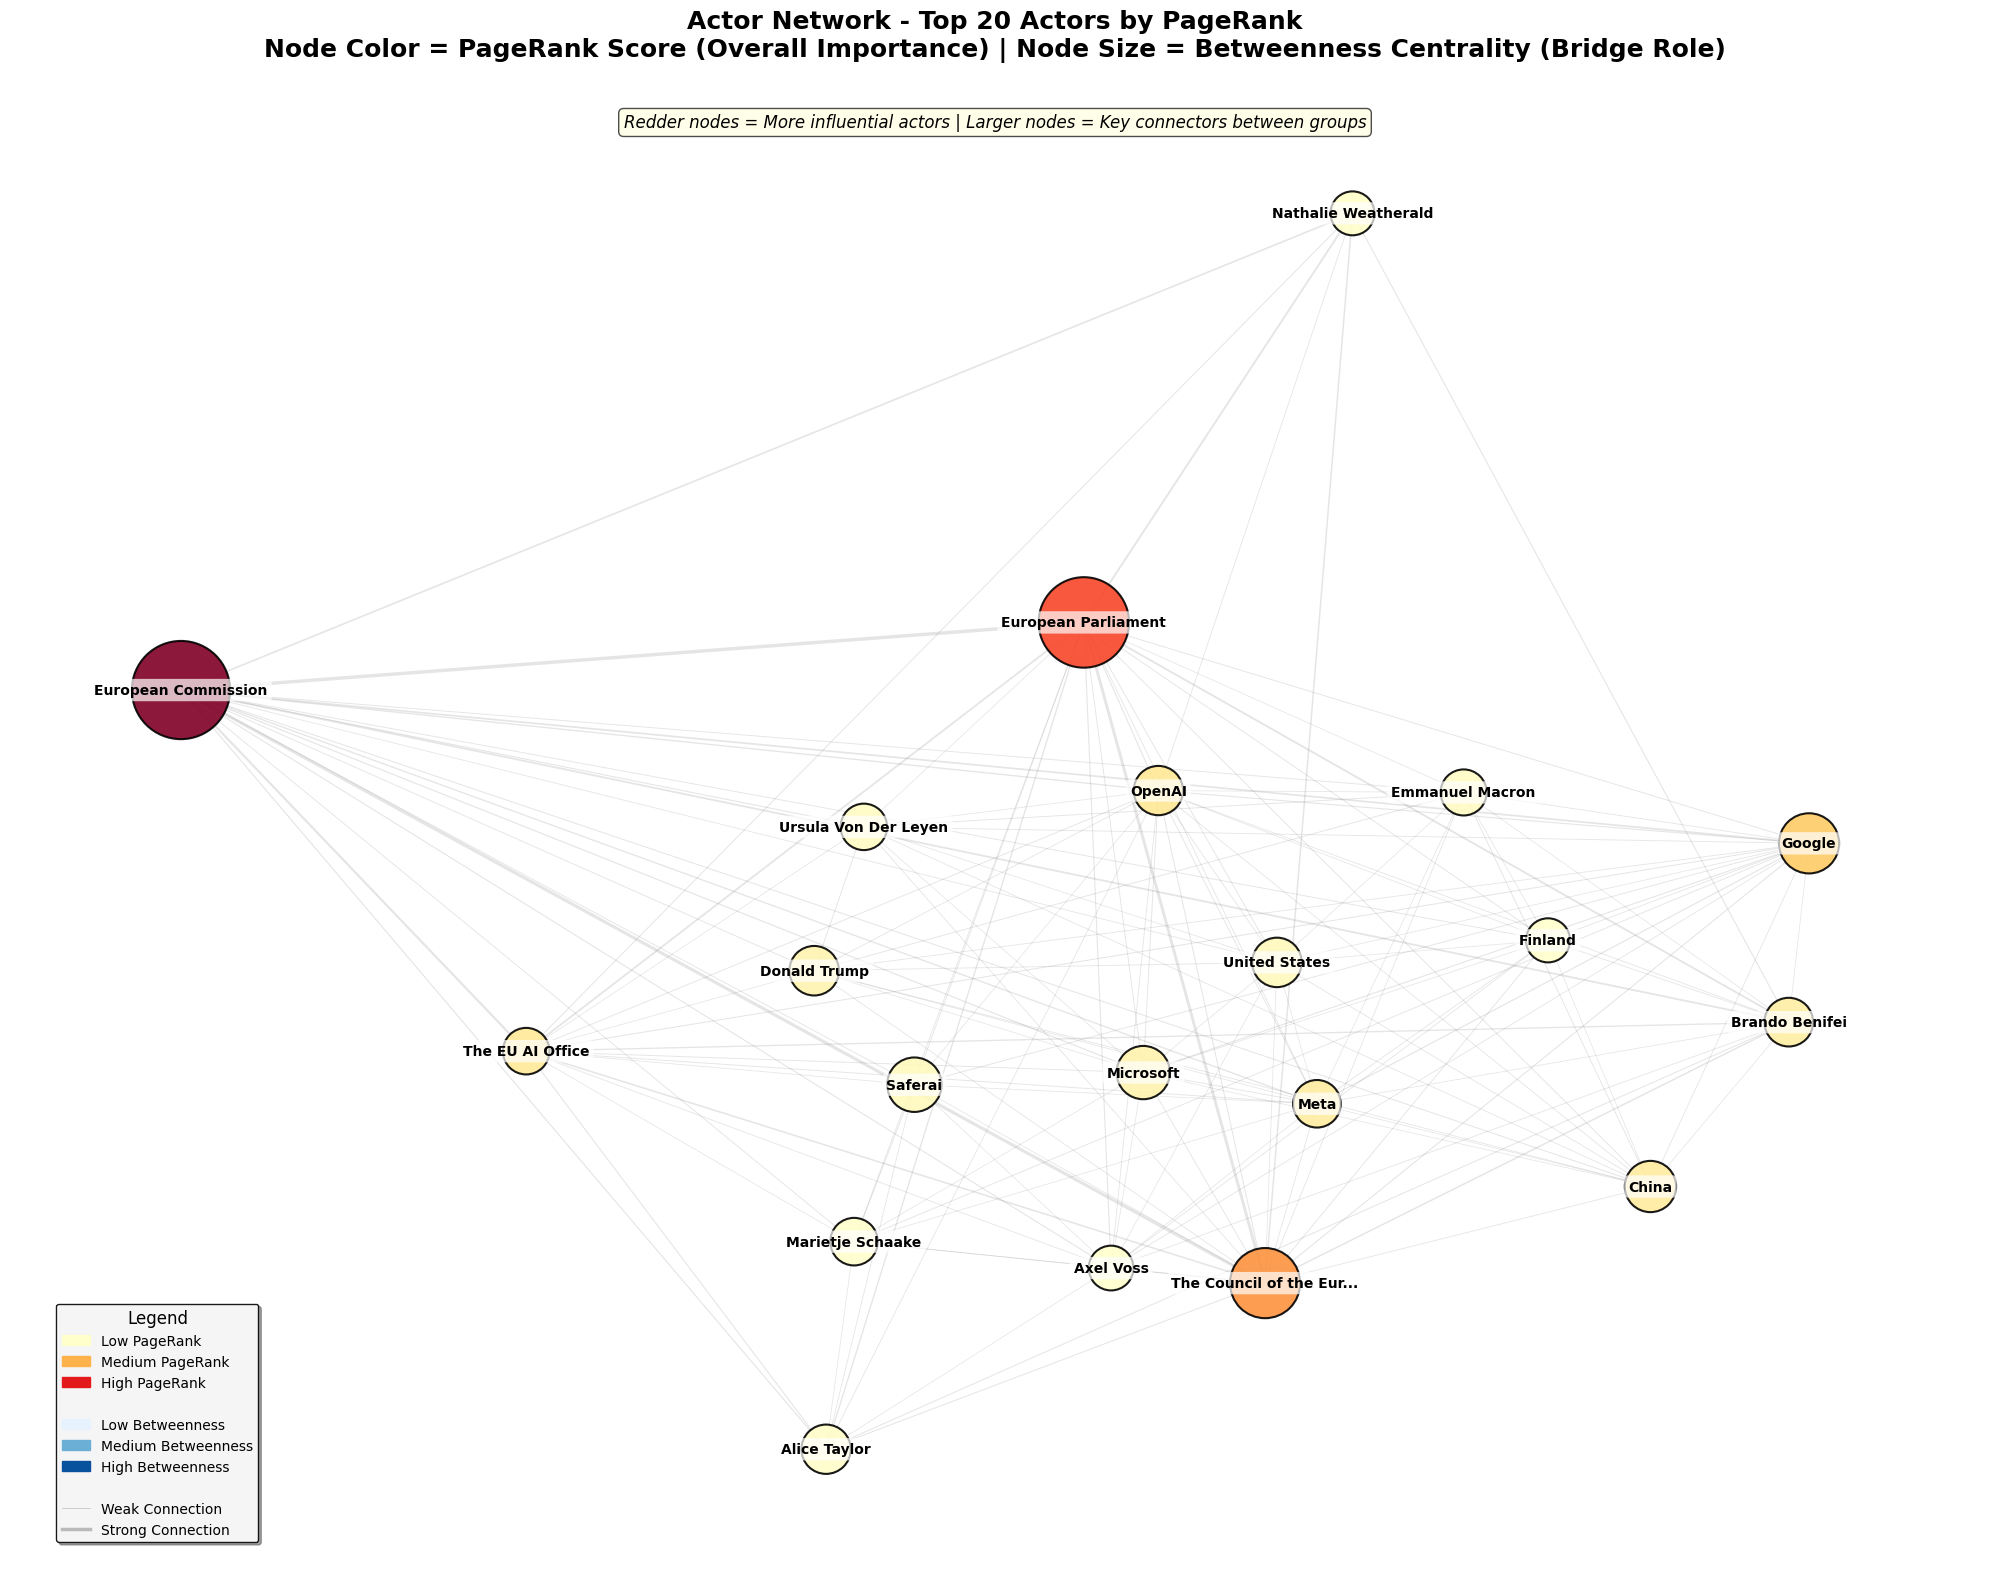

Visualization saved as 'enhanced_actor_network.png'


In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def create_enhanced_network_visualization(G, centrality_measures, top_n=20):
    """Create an enhanced network visualization with better readability and legend"""

    fig, ax = plt.subplots(figsize=(20, 16))
    top_nodes = sorted(centrality_measures['pagerank'].items(),
                      key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = [node[0] for node in top_nodes]

    subgraph = G.subgraph(top_node_names)

    pos = nx.kamada_kawai_layout(subgraph, scale=3)

    pagerank_values = [centrality_measures['pagerank'][node] for node in subgraph.nodes()]

    #node sizes based on betweenness centrality
    betweenness_values = [centrality_measures['betweenness'][node] for node in subgraph.nodes()]
    min_bt = min(betweenness_values)
    max_bt = max(betweenness_values)
    node_sizes = [
        1000 + (centrality_measures['betweenness'][node] - min_bt) / (max_bt - min_bt) * 4000
        for node in subgraph.nodes()
    ]

    edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [0.5 + (w/max_weight) * 2 for w in edge_weights]

    nx.draw_networkx_edges(
        subgraph, pos,
        alpha=0.2,
        width=edge_widths,
        edge_color='gray'
    )

    nodes = nx.draw_networkx_nodes(
        subgraph, pos,
        node_size=node_sizes,
        node_color=pagerank_values,
        cmap='YlOrRd',
        alpha=0.9,
        edgecolors='black',
        linewidths=1.5
    )

    labels = {}
    for node in subgraph.nodes():
        if len(node) > 25:
            labels[node] = node[:22] + "..."
        else:
            labels[node] = node

    for node, (x, y) in pos.items():
        ax.text(x, y, labels[node],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=10,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3",
                         facecolor='white',
                         edgecolor='none',
                         alpha=0.7))


    legend_elements = []
    legend_elements.append(mpatches.Patch(color='#FFFFCC', label='Low PageRank'))
    legend_elements.append(mpatches.Patch(color='#FEB24C', label='Medium PageRank'))
    legend_elements.append(mpatches.Patch(color='#E31A1C', label='High PageRank'))
    legend_elements.append(Line2D([0], [0], color='none', label=''))

    #node size legend (Betweenness)
    legend_elements.append(mpatches.Patch(color='#E6F3FF', label='Low Betweenness'))
    legend_elements.append(mpatches.Patch(color='#6BAED6', label='Medium Betweenness'))
    legend_elements.append(mpatches.Patch(color='#08519C', label='High Betweenness'))

    #spacing
    legend_elements.append(Line2D([0], [0], color='none', label=''))

    legend_elements.append(Line2D([0], [0], color='gray', linewidth=0.5, alpha=0.5, label='Weak Connection'))
    legend_elements.append(Line2D([0], [0], color='gray', linewidth=2.5, alpha=0.5, label='Strong Connection'))

    legend = ax.legend(
        handles=legend_elements,
        loc='lower left',
        bbox_to_anchor=(0.02, 0.02),
        frameon=True,
        fancybox=True,
        shadow=True,
        title='Legend',
        title_fontsize=12,
        fontsize=10,
        ncol=1
    )


    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('black')


    plt.title(f'Actor Network - Top {top_n} Actors by PageRank\n' +
              'Node Color = PageRank Score (Overall Importance) | ' +
              'Node Size = Betweenness Centrality (Bridge Role)',
              fontsize=18, fontweight='bold', pad=20)


    ax.text(0.5, 0.98,
            'Redder nodes = More influential actors | Larger nodes = Key connectors between groups',
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=12, style='italic',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.7))


    ax.set_axis_off()

    plt.tight_layout()

    ax.grid(True, alpha=0.1, linestyle='--')

    return fig, ax

print("Creating enhanced network visualization...")


fig, ax = create_enhanced_network_visualization(G, centrality_measures, top_n=20)
plt.savefig('enhanced_actor_network.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'enhanced_actor_network.png'")

In [12]:
# Q2: Measuring intensity and distribution of connections
# ============================================================================

def create_cooccurrence_matrix(df, min_frequency=3):
    """
    Create co-occurrence matrix based on actors appearing in the same article
    """
    #filtering actors that appear at least min_frequency times
    frequent_actors = [actor for actor, count in actor_counts.items() if count >= min_frequency]

    #co-occurrence matrix
    cooccurrence = defaultdict(lambda: defaultdict(int))

    for _, row in df.iterrows():
        actors_in_article = [actor for actor in row['final_actors'] if actor in frequent_actors]

        #counting co-occurrences
        for i, actor1 in enumerate(actors_in_article):
            for j, actor2 in enumerate(actors_in_article):
                if i != j:  # Don't count self-occurrences
                    cooccurrence[actor1][actor2] += 1

    return cooccurrence, frequent_actors

cooccurrence_matrix, frequent_actors = create_cooccurrence_matrix(df, min_frequency=3)

cooccurrence_df = pd.DataFrame(
    [[cooccurrence_matrix[actor1][actor2] for actor2 in frequent_actors]
     for actor1 in frequent_actors],
    index=frequent_actors,
    columns=frequent_actors
)

print("\nConnection intensity matrix shape:", cooccurrence_df.shape)
print("Top connections:")
#top connections (excluding diagonal)
connections = []
for i in range(len(frequent_actors)):
    for j in range(i+1, len(frequent_actors)):
        actor1, actor2 = frequent_actors[i], frequent_actors[j]
        intensity = cooccurrence_df.loc[actor1, actor2] + cooccurrence_df.loc[actor2, actor1]
        if intensity > 0:
            connections.append((actor1, actor2, intensity))

connections.sort(key=lambda x: x[2], reverse=True)
for actor1, actor2, intensity in connections[:10]:
    print(f"{actor1} <-> {actor2}: {intensity}")


Connection intensity matrix shape: (51, 51)
Top connections:
European Commission <-> European Parliament: 68
European Commission <-> The Council of the European Union: 60
European Parliament <-> The Council of the European Union: 54
European Commission <-> The EU AI Office: 38
European Parliament <-> Brando Benifei: 30
European Parliament <-> Nathalie Weatherald: 30
European Commission <-> Brando Benifei: 28
European Parliament <-> The EU AI Office: 28
European Commission <-> Google: 26
European Commission <-> Nathalie Weatherald: 24


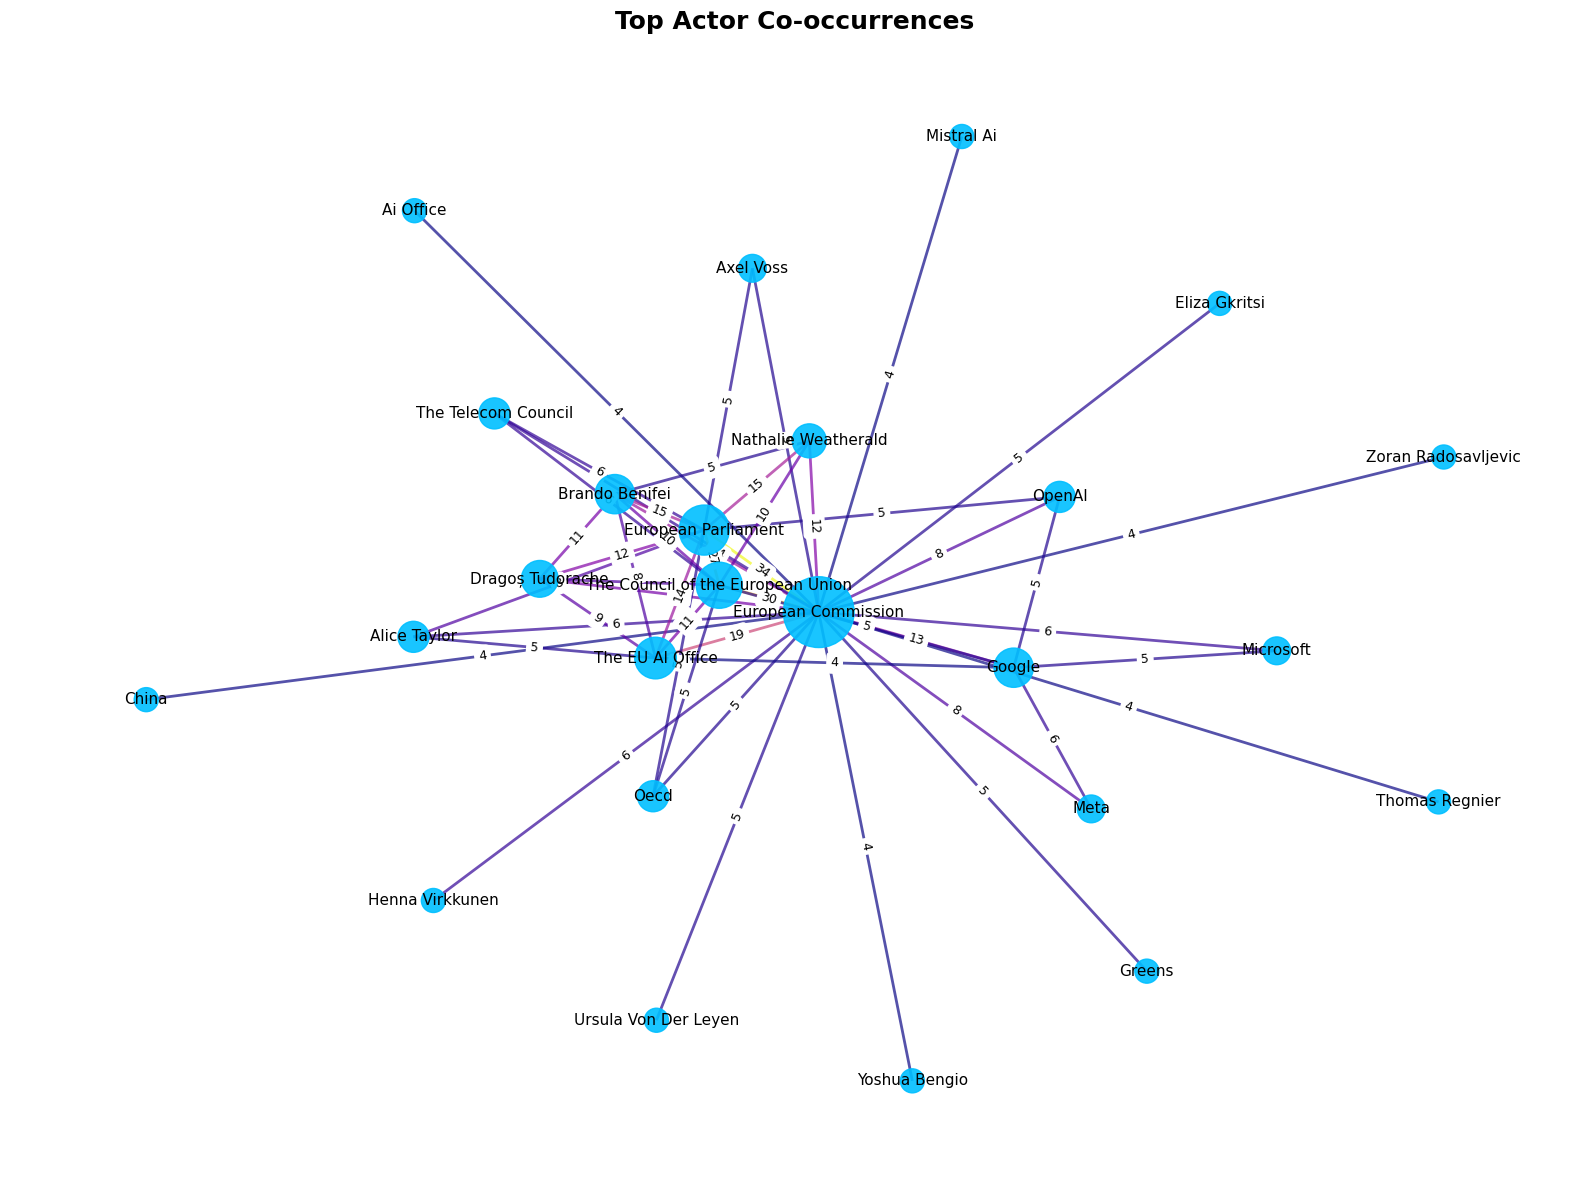

In [13]:
import matplotlib.colors as mcolors

def visualize_cooccurrence_network(cooccurrence_df, top_n=50, show_weights=False):
    G = nx.Graph()

    for i in range(len(cooccurrence_df)):
        for j in range(i + 1, len(cooccurrence_df.columns)):
            actor1 = cooccurrence_df.index[i]
            actor2 = cooccurrence_df.columns[j]
            weight = cooccurrence_df.iloc[i, j]

            if weight > 0:
                G.add_edge(actor1, actor2, weight=weight)


    top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:top_n]
    H = nx.Graph()
    H.add_edges_from(top_edges)

    #
    degrees = dict(H.degree())
    node_sizes = [200 + degrees[node] * 100 for node in H.nodes()]

    #
    weights = [d['weight'] for _, _, d in H.edges(data=True)]
    max_weight = max(weights) if weights else 1
    norm = mcolors.Normalize(vmin=min(weights), vmax=max_weight)
    cmap = plt.cm.plasma
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in H.edges(data=True)]

    #
    pos = nx.spring_layout(H, k=0.4, seed=42)
    plt.figure(figsize=(16, 12))

    nx.draw_networkx_nodes(H, pos, node_color="deepskyblue", node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=11, font_family="sans-serif")

    #
    if show_weights:
        edge_labels = {(u, v): f"{d['weight']}" for u, v, d in H.edges(data=True)}
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Top Actor Co-occurrences", fontsize=18, fontweight='bold')
    plt.axis("off")
    plt.tight_layout()
    plt.show()
visualize_cooccurrence_network(cooccurrence_df, top_n=50, show_weights=True)

In [15]:
# Q3 - Using semantic analysis to determine whether interactions are one-way,mutual, or undirected
# ============================================================================
import nltk
nltk.download('punkt_tab')
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
from collections import defaultdict, Counter

class InteractionAnalyzer:
    def __init__(self):
        # Define patterns for different interaction types
        self.patterns = {
            'one_way': [
                # A tells/informs/announces to B
                r'(\w+(?:\s+\w+)*)\s+(?:told|informed|announced to|stated to|said to|declared to|warned|advised|instructed|ordered)\s+(\w+(?:\s+\w+)*)',

                # A criticizes/attacks/blames B
                r'(\w+(?:\s+\w+)*)\s+(?:criticized|attacked|blamed|accused|condemned|slammed|rejected|opposed)\s+(\w+(?:\s+\w+)*)',

                # A supports/endorses/backs B
                r'(\w+(?:\s+\w+)*)\s+(?:supported|endorsed|backed|praised|commended|applauded)\s+(\w+(?:\s+\w+)*)',

                # A proposes/suggests to B
                r'(\w+(?:\s+\w+)*)\s+(?:proposed to|suggested to|recommended to|urged|called on|asked)\s+(\w+(?:\s+\w+)*)',

                # A said (general statement)
                r'(\w+(?:\s+\w+)*)\s+(?:said|stated|argued|claimed|maintained|insisted|emphasized|noted|explained|added|continued)',

                # According to A
                r'(?:according to|as stated by|as per)\s+(\w+(?:\s+\w+)*)',

                # B responds to A
                r'(\w+(?:\s+\w+)*)\s+(?:responded to|replied to|reacted to|answered)\s+(\w+(?:\s+\w+)*)',
            ],

            'mutual': [
                # A and B discuss/negotiate/debate
                r'(\w+(?:\s+\w+)*)\s+and\s+(\w+(?:\s+\w+)*)\s+(?:discussed|negotiated|debated|argued|disagreed|agreed|collaborated|cooperated|partnered)',

                # A meets with B
                r'(\w+(?:\s+\w+)*)\s+(?:met with|held talks with|had discussions with)\s+(\w+(?:\s+\w+)*)',

                # Meeting between A and B
                r'(?:meeting|talks|discussion|dialogue|summit)\s+between\s+(\w+(?:\s+\w+)*)\s+and\s+(\w+(?:\s+\w+)*)',

                # Both A and B
                r'(?:both\s+)?(\w+(?:\s+\w+)*)\s+and\s+(\w+(?:\s+\w+)*)\s+(?:agreed|decided|concluded|announced|stated|called for)',
            ],

            'undirected': [
                # A along with B
                r'(\w+(?:\s+\w+)*)\s+(?:along with|together with|as well as|including)\s+(\w+(?:\s+\w+)*)',

                # A, B listed together
                r'(\w+(?:\s+\w+)*)\s*,\s*(\w+(?:\s+\w+)*)\s*(?:,\s*and\s+others|,\s*among others)',
            ]
        }

    def normalize_actor_name(self, actor_name, actor_list):
        """Find the best match for an actor name in our cleaned list"""
        if not actor_name:
            return None

        actor_clean = actor_name.strip().title()

        # Remove common prefixes/suffixes
        actor_clean = re.sub(r'^(?:The\s+|Mr\s+|Ms\s+|Dr\s+)', '', actor_clean)

        # Try exact match first
        if actor_clean in actor_list:
            return actor_clean

        # Try partial matches
        for actor in actor_list:
            if actor_clean in actor or actor in actor_clean:
                return actor

        return None

    def simple_sent_tokenize(self, text):
        """Simple sentence tokenizer"""
        sentences = re.split(r'[.!?]+\s+', text)
        return [s.strip() for s in sentences if len(s.strip()) > 20]  # Filter very short sentences

    def analyze_article_interactions(self, article_text, article_actors):
        """Analyze all interactions in a single article"""
        interactions = []

        # Split into sentences
        sentences = self.simple_sent_tokenize(article_text)

        for sentence in sentences:
            # Check each pattern type
            for pattern_type, patterns in self.patterns.items():
                for pattern in patterns:
                    matches = re.finditer(pattern, sentence, re.IGNORECASE)

                    for match in matches:
                        groups = match.groups()
                        if len(groups) >= 1:
                            if len(groups) == 1:  # General statement (like "A said")
                                actor1 = self.normalize_actor_name(groups[0], article_actors)
                                if actor1:
                                    interactions.append({
                                        'type': 'one_way',
                                        'source': actor1,
                                        'target': None,
                                        'context': sentence[:200],
                                        'pattern_type': pattern_type
                                    })

                            elif len(groups) >= 2:  # Interaction between two actors
                                actor1 = self.normalize_actor_name(groups[0], article_actors)
                                actor2 = self.normalize_actor_name(groups[1], article_actors)

                                if actor1 and actor2 and actor1 != actor2:
                                    if pattern_type == 'one_way':
                                        interactions.append({
                                            'type': 'one_way',
                                            'source': actor1,
                                            'target': actor2,
                                            'context': sentence[:200],
                                            'pattern_type': pattern_type
                                        })
                                    elif pattern_type == 'mutual':
                                        interactions.append({
                                            'type': 'mutual',
                                            'actor1': actor1,
                                            'actor2': actor2,
                                            'context': sentence[:200],
                                            'pattern_type': pattern_type
                                        })
                                    elif pattern_type == 'undirected':
                                        interactions.append({
                                            'type': 'undirected',
                                            'actor1': actor1,
                                            'actor2': actor2,
                                            'context': sentence[:200],
                                            'pattern_type': pattern_type
                                        })

        return interactions

    def analyze_corpus_interactions(self, df):
        """Analyze interactions across the entire corpus"""
        print("Processing articles...")

        all_interactions = []
        interaction_counts = defaultdict(lambda: defaultdict(int))

        for idx, row in df.iterrows():
            if idx % 10 == 0:  # Progress indicator
                print(f"Processed {idx}/{len(df)} articles...")

            article_interactions = self.analyze_article_interactions(
                row['text'],
                row['final_actors']
            )

            all_interactions.extend(article_interactions)

            # Count interactions by type and actor pairs
            for interaction in article_interactions:
                if interaction['type'] == 'one_way' and interaction['target']:
                    pair = f"{interaction['source']} -> {interaction['target']}"
                    interaction_counts[pair]['one_way'] += 1
                elif interaction['type'] == 'mutual':
                    # Sort to ensure consistent pair representation
                    actors = sorted([interaction['actor1'], interaction['actor2']])
                    pair = f"{actors[0]} <-> {actors[1]}"
                    interaction_counts[pair]['mutual'] += 1
                elif interaction['type'] == 'undirected':
                    # Sort to ensure consistent pair representation
                    actors = sorted([interaction['actor1'], interaction['actor2']])
                    pair = f"{actors[0]} ~ {actors[1]}"
                    interaction_counts[pair]['undirected'] += 1

        print(f"Finished processing {len(df)} articles!")
        return all_interactions, interaction_counts

    def generate_interaction_report(self, interaction_counts):
        """Generate a comprehensive report of interactions"""
        report = []

        # Aggregate by unique actor pairs
        pair_summary = defaultdict(lambda: {'one_way': 0, 'mutual': 0, 'undirected': 0})

        for pair, counts in interaction_counts.items():
            # Extract actors from pair string
            if ' -> ' in pair:
                actors = pair.split(' -> ')
                key = tuple(sorted(actors))
                pair_summary[key]['one_way'] += counts['one_way']
            elif ' <-> ' in pair:
                actors = pair.split(' <-> ')
                key = tuple(sorted(actors))
                pair_summary[key]['mutual'] += counts['mutual']
            elif ' ~ ' in pair:
                actors = pair.split(' ~ ')
                key = tuple(sorted(actors))
                pair_summary[key]['undirected'] += counts['undirected']

        # Create report
        for pair, counts in pair_summary.items():
            if len(pair) == 2:
                total = counts['one_way'] + counts['mutual'] + counts['undirected']
                if total > 0:
                    # Determine dominant relationship type
                    if counts['mutual'] > counts['one_way'] and counts['mutual'] > counts['undirected']:
                        relationship_type = 'mutual'
                    elif counts['one_way'] > counts['mutual'] and counts['one_way'] > counts['undirected']:
                        relationship_type = 'one_way'
                    elif counts['undirected'] > counts['mutual'] and counts['undirected'] > counts['one_way']:
                        relationship_type = 'undirected'
                    else:
                        relationship_type = 'mixed'

                    report.append({
                        'actor1': pair[0],
                        'actor2': pair[1],
                        'relationship_type': relationship_type,
                        'total_interactions': total,
                        'one_way_count': counts['one_way'],
                        'mutual_count': counts['mutual'],
                        'undirected_count': counts['undirected']
                    })

        return sorted(report, key=lambda x: x['total_interactions'], reverse=True)



#
analyzer = InteractionAnalyzer()
print("Analyzing semantic interactions...")
all_interactions, interaction_counts = analyzer.analyze_corpus_interactions(df)
interaction_report = analyzer.generate_interaction_report(interaction_counts)

print(f"\nAnalysis Complete!")
print(f"Total interactions found: {len(all_interactions)}")
print(f"Unique actor pairs: {len(interaction_report)}")

#counting by type
one_way_total = sum(1 for i in all_interactions if i['type'] == 'one_way')
mutual_total = sum(1 for i in all_interactions if i['type'] == 'mutual')
undirected_total = sum(1 for i in all_interactions if i['type'] == 'undirected')

print(f"One-way interactions: {one_way_total}")
print(f"Mutual interactions: {mutual_total}")
print(f"Undirected interactions: {undirected_total}")

print("\n" + "="*80)
print("TOP 20 ACTOR PAIRS BY INTERACTION FREQUENCY")
print("="*80)

for i, report in enumerate(interaction_report[:20]):
    print(f"\n{i+1:2d}. {report['actor1']} <-> {report['actor2']}")
    print(f"    Relationship Type: {report['relationship_type'].upper()}")
    print(f"    Total: {report['total_interactions']} | One-way: {report['one_way_count']} | Mutual: {report['mutual_count']} | Undirected: {report['undirected_count']}")

# Show some example interactions
print("\n" + "="*80)
print("EXAMPLE INTERACTIONS")
print("="*80)

interaction_types = ['one_way', 'mutual', 'undirected']
for itype in interaction_types:
    examples = [i for i in all_interactions if i['type'] == itype]
    if examples:
        print(f"\n{itype.upper()} Examples:")
        for i, example in enumerate(examples[:3]):
            print(f"{i+1}. {example['context']}")
            if itype == 'one_way':
                target = example['target'] if example['target'] else 'General'
                print(f"   [{example['source']} -> {target}]")
            else:
                print(f"   [{example['actor1']} <-> {example['actor2']}]")
            print()

#simple network summary
print("\n" + "="*80)
print("NETWORK SUMMARY")
print("="*80)

#most active actors
actor_activity = defaultdict(int)
for interaction in all_interactions:
    if interaction['type'] == 'one_way':
        actor_activity[interaction['source']] += 1
        if interaction['target']:
            actor_activity[interaction['target']] += 1
    else:
        actor_activity[interaction['actor1']] += 1
        actor_activity[interaction['actor2']] += 1

print("Most Active Actors:")
for actor, activity in sorted(actor_activity.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {actor}: {activity} interactions")

#relationship type distribution
relationship_dist = defaultdict(int)
for report in interaction_report:
    relationship_dist[report['relationship_type']] += 1

print(f"\nRelationship Type Distribution:")
for rel_type, count in sorted(relationship_dist.items(), key=lambda x: x[1], reverse=True):
    print(f"  {rel_type}: {count} pairs")

Analyzing semantic interactions...
Processing articles...
Processed 0/84 articles...
Processed 10/84 articles...
Processed 40/84 articles...
Processed 50/84 articles...
Processed 80/84 articles...
Processed 1200/84 articles...
Processed 1210/84 articles...
Processed 1850/84 articles...
Finished processing 84 articles!

Analysis Complete!
Total interactions found: 75
Unique actor pairs: 5
One-way interactions: 73
Mutual interactions: 2
Undirected interactions: 0

TOP 20 ACTOR PAIRS BY INTERACTION FREQUENCY

 1. Google <-> Henna Virkkunen
    Relationship Type: ONE_WAY
    Total: 1 | One-way: 1 | Mutual: 0 | Undirected: 0

 2. Microsoft <-> Mistral Ai
    Relationship Type: MUTUAL
    Total: 1 | One-way: 0 | Mutual: 1 | Undirected: 0

 3. Ashkan Soltani <-> Didier Reynders
    Relationship Type: MUTUAL
    Total: 1 | One-way: 0 | Mutual: 1 | Undirected: 0

 4. Blair <-> Javi López
    Relationship Type: ONE_WAY
    Total: 1 | One-way: 1 | Mutual: 0 | Undirected: 0

 5. Erik Marquardt <->

In [18]:
for i, report in enumerate(interaction_report[:10]):
    print(f"{i+1}. {report['actor1']} <-> {report['actor2']}")
    print(f"   Relationship Type: {report['relationship_type']}")
    print(f"   Total Interactions: {report['total_interactions']}")
    print(f"   One-way: {report['one_way_count']}, Mutual: {report['mutual_count']}, Undirected: {report['undirected_count']}\n")

interaction_df = pd.DataFrame(interaction_report)
interaction_df.to_csv("semantic_interactions.csv", index=False)
from google.colab import files
files.download("semantic_interactions.csv")

1. Google <-> Henna Virkkunen
   Relationship Type: one_way
   Total Interactions: 1
   One-way: 1, Mutual: 0, Undirected: 0

2. Microsoft <-> Mistral Ai
   Relationship Type: mutual
   Total Interactions: 1
   One-way: 0, Mutual: 1, Undirected: 0

3. Ashkan Soltani <-> Didier Reynders
   Relationship Type: mutual
   Total Interactions: 1
   One-way: 0, Mutual: 1, Undirected: 0

4. Blair <-> Javi López
   Relationship Type: one_way
   Total Interactions: 1
   One-way: 1, Mutual: 0, Undirected: 0

5. Erik Marquardt <-> Micallef
   Relationship Type: one_way
   Total Interactions: 1
   One-way: 1, Mutual: 0, Undirected: 0



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
!pip install networkx matplotlib

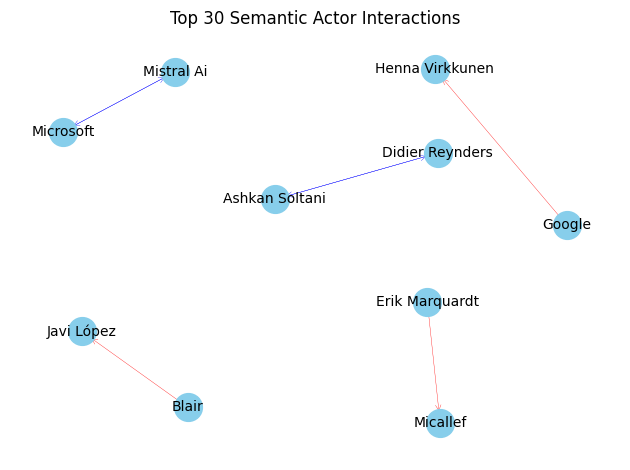

In [20]:
def visualize_interaction_network(interaction_report, top_n=30):
    G = nx.DiGraph()  # DiGraph for direction

    #top N interactions
    top_pairs = sorted(interaction_report, key=lambda x: x['total_interactions'], reverse=True)[:top_n]

    for interaction in top_pairs:
        a1 = interaction['actor1']
        a2 = interaction['actor2']
        weight = interaction['total_interactions']
        relation = interaction['relationship_type']

        if relation == 'mutual':
            G.add_edge(a1, a2, weight=weight, color='blue', label='mutual')
            G.add_edge(a2, a1, weight=weight, color='blue', label='mutual')  # Symmetric
        elif relation == 'one_way':
            G.add_edge(a1, a2, weight=weight, color='red', label='one_way')
        elif relation == 'undirected':
            G.add_edge(a1, a2, weight=weight, color='gray', label='undirected')
            G.add_edge(a2, a1, weight=weight, color='gray', label='undirected')
        elif relation == 'mixed':
            G.add_edge(a1, a2, weight=weight, color='purple', label='mixed')
            G.add_edge(a2, a1, weight=weight, color='purple', label='mixed')

    pos = nx.spring_layout(G, k=1.2)
    colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    #nodes, edges and labels
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=400)
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=[w / 4 for w in edge_weights], arrows=True, arrowstyle='->')
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(f"Top {top_n} Semantic Actor Interactions")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_interaction_network(interaction_report)

In [21]:
interaction_df = pd.DataFrame(interaction_report)

interaction_df = interaction_df.rename(columns={
    'actor1': 'Actor 1',
    'actor2': 'Actor 2',
    'relationship_type': 'Relation Type',
    'total_interactions': 'Total Interactions',
    'one_way_count': 'One-way Count',
    'mutual_count': 'Mutual Count',
    'undirected_count': 'Undirected Count'
})

from IPython.display import display
display(interaction_df)

,Actor 1,Actor 2,Relation Type,Total Interactions,One-way Count,Mutual Count,Undirected Count
0,Google,Henna Virkkunen,one_way,1,1,0,0
1,Microsoft,Mistral Ai,mutual,1,0,1,0
2,Ashkan Soltani,Didier Reynders,mutual,1,0,1,0
3,Blair,Javi López,one_way,1,1,0,0
4,Erik Marquardt,Micallef,one_way,1,1,0,0


In [22]:
# Network statistics (check the word document)
# ============================================================================

def create_network_graph(cooccurrence_df, min_connection_strength=2):
    """
    Create a NetworkX graph from the co-occurrence matrix
    """
    G = nx.Graph()

    #nodes
    for actor in cooccurrence_df.index:
        G.add_node(actor, frequency=actor_counts[actor])

    #edges
    for i in range(len(cooccurrence_df.index)):
        for j in range(i+1, len(cooccurrence_df.columns)):
            actor1, actor2 = cooccurrence_df.index[i], cooccurrence_df.columns[j]
            weight = cooccurrence_df.iloc[i, j] + cooccurrence_df.iloc[j, i]

            if weight >= min_connection_strength:
                G.add_edge(actor1, actor2, weight=weight)

    return G

network = create_network_graph(cooccurrence_df, min_connection_strength=2)

print(f"\nNetwork statistics:")
print(f"Number of nodes: {network.number_of_nodes()}")
print(f"Number of edges: {network.number_of_edges()}")
print(f"Network density: {nx.density(network):.3f}")

#communities/clusters
try:
    communities = nx.community.greedy_modularity_communities(network)
    print(f"Number of communities found: {len(communities)}")
    for i, community in enumerate(communities):
        if len(community) > 2:  #only larger communities
            print(f"Community {i+1}: {list(community)}")
except:
    print("Community detection failed - network might be too sparse")

#centrality measures
centrality_measures = {
    'degree': nx.degree_centrality(network),
    'betweenness': nx.betweenness_centrality(network),
    'closeness': nx.closeness_centrality(network),
    'eigenvector': nx.eigenvector_centrality(network, max_iter=1000)
}

print("\nTop actors by centrality measures:")
for measure_name, measure_values in centrality_measures.items():
    top_actors = sorted(measure_values.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"{measure_name.title()} centrality:")
    for actor, score in top_actors:
        print(f"  {actor}: {score:.3f}")


Network statistics:
Number of nodes: 51
Number of edges: 551
Network density: 0.432
Number of communities found: 3
Community 1: ['The Eu Ai Office', 'Kim Van Sparrentak', 'Trade And Technology Council', 'Zoran Radosavljevic', 'Greens', 'Dragoș Tudorache', 'Alice Taylor', 'Beuc', 'Amazon', 'Nathalie Weatherald', 'European Peoples Party', 'The Telecom Council', 'Finland', 'Brando Benifei', 'The European Consumer Organisation', 'European Parliament', 'The Council of the European Union']
Community 2: ['Simeon Campos', 'The EU AI Office', 'Axel Voss', 'Mistral Ai', 'Saferai', 'Yoshua Bengio', 'Henna Virkkunen', 'Anthropic', 'Meta', 'Marietje Schaake', 'Thomas Regnier', 'OpenAI', 'Microsoft', 'Ai Office', 'Stanford University', 'Eliza Gkritsi', 'Google']
Community 3: ['Emmanuel Macron', 'China', 'Donald Trump', 'Joe Biden', 'India', 'Brian Maguire', 'Nvidia', 'Sam Altman', 'Emanuel Macron', 'Ursula Von Der Leyen', 'European Commission', 'Ceps', 'Brazil', 'Ukraine', 'Oecd', 'United States', 

In [23]:
#Q4 - Categorizing actors as pro-security, pro-privacy, or neutral
# ============================================================================

In [30]:
from collections import defaultdict


stance_keywords = {
    "pro_privacy": [
        "privacy", "data protection", "fundamental rights", "civil liberties",
        "GDPR", "transparency", "surveillance concerns", "oversight",
        "human rights", "ethical", "freedom", "rights-based"
    ],
    "pro_security": [
        "cybersecurity", "national security", "law enforcement", "surveillance",
        "terrorism", "military", "threat", "intelligence", "border control",
        "public safety", "crime", "risk mitigation", "robust monitoring"
    ],
    "neutral": [
        "balance", "stakeholder", "governance", "market", "AI regulation",
        "innovation", "economic growth", "standardisation", "implementation",
        "framework", "compliance", "coordination"
    ]
}

def detect_stance_from_sentence(sentence):
    """Return a dictionary with counts of stance keywords in the sentence."""
    counts = {"pro_privacy": 0, "pro_security": 0, "neutral": 0}
    lowered = sentence.lower()
    for stance, keywords in stance_keywords.items():
        for kw in keywords:
            if kw in lowered:
                counts[stance] += 1
    return counts

# STANCE ANALYSES FOR EVERY ACTOR
def classify_actor_stance(df, top_actors):
    actor_stances = defaultdict(lambda: {"pro_privacy": 0, "pro_security": 0, "neutral": 0, "total_mentions": 0})

    for _, row in df.iterrows():
        text = row['text']
        sentences = re.split(r'[.!?]+\s+', text)

        for sentence in sentences:
            for actor in top_actors:
                if actor.lower() in sentence.lower():
                    stance_count = detect_stance_from_sentence(sentence)
                    for k in stance_count:
                        actor_stances[actor][k] += stance_count[k]
                    actor_stances[actor]["total_mentions"] += 1

    #
    actor_classification = []
    for actor, counts in actor_stances.items():
        max_stance = max(["pro_privacy", "pro_security", "neutral"], key=lambda x: counts[x])
        actor_classification.append({
            "actor": actor,
            "stance": max_stance,
            "pro_privacy": counts["pro_privacy"],
            "pro_security": counts["pro_security"],
            "neutral": counts["neutral"],
            "total_mentions": counts["total_mentions"]
        })

    return pd.DataFrame(actor_classification).sort_values(by="total_mentions", ascending=False)


top_actors = ['European Commission', 'European Parliament', 'EDPB', 'EDPS',
              'France', 'Germany', 'Ursula Von Der Leyen', 'ChatGPT',
              'Microsoft', 'OpenAI', 'European Council']

df = pd.read_csv('scrapped_euractiv.csv')
stance_df = classify_actor_stance(df, top_actors)


print("=" * 80)
print("ACTOR STANCE CLASSIFICATION RESULTS")
print("=" * 80)
print("\n", stance_df.to_string(index=False))

#statistics
print("\n" + "=" * 80)
print("STANCE DISTRIBUTION SUMMARY:")
print("=" * 80)


stance_summary = stance_df.groupby('stance').size()
print("\nActors by dominant stance:")
for stance, count in stance_summary.items():
    actors_with_stance = stance_df[stance_df['stance'] == stance]['actor'].tolist()
    print(f"\n{stance.upper()} ({count} actors):")
    for actor in actors_with_stance:
        mentions = stance_df[stance_df['actor'] == actor]['total_mentions'].values[0]
        print(f"  - {actor} ({mentions} mentions)")

#top mentioned actors
print("\n" + "=" * 80)
print("TOP 5 MOST MENTIONED ACTORS:")
print("=" * 80)
if len(stance_df) > 0:
    top_5 = stance_df.head(5)
    for idx, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"\n{idx}. {row['actor']}")
        print(f"   Stance: {row['stance']}")
        print(f"   Total mentions: {row['total_mentions']}")
        print(f"   Keyword counts - Privacy: {row['pro_privacy']}, Security: {row['pro_security']}, Neutral: {row['neutral']}")
else:
    print("No actors found in the dataset")

print("\n" + "=" * 80)

ACTOR STANCE CLASSIFICATION RESULTS

                actor       stance  pro_privacy  pro_security  neutral  total_mentions
             Germany pro_security            9            52       32             780
 European Commission      neutral           18            31       58             636
              France pro_security            8            45       25             530
 European Parliament      neutral           22            23       26             427
Ursula Von Der Leyen      neutral            0             7       15             143
    European Council pro_security            0             4        2              88
             ChatGPT  pro_privacy           12             7        3              68
              OpenAI  pro_privacy            9             1        0              40
           Microsoft      neutral            3             1        5              38
                EDPS  pro_privacy            4             1        1               9
                